In [1]:
%%capture
!pip install tensorflow
!pip install keras_tuner

In [2]:
%%capture

import pandas as pd 
import time
import numpy as np 
import os
import requests
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

2025-07-01 04:19:21.741312: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-01 04:19:21.748021: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-01 04:19:21.763772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751343561.790402     136 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751343561.798022     136 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751343561.819098     136 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Original Data Source

The original data for this project is sourced from https://optiondata.org/. They have graciously provided free sample datasets for option prices and stock prices from January 2013 to June 2013. The data we will be using is from the month of February 2013 located in the `2013-02.zip` file located on their website.  

## Data Preprocessing

The dataset we will be using is fairly large, there are 19 trading days in the month of February 2013 and two different csv files for each day, the first being the options data and the second being the stock price data. 

To simplify this, we will first join the two datasets through the `symbol` column in the stocks files, and the `underlying` column in the options files. This will allow us to access the data for both in a single file for our features later.

After reviewing the files, we found there were around 500,000 rows for 3800 unique tickers on each trading day, with 19 different days that meant we were looking at close to 9.5 million rows of data. Training machine learning algorithms on this much data will take a very long time, so to minimize this effect, we decided to filter the data to a subset of S&P 100 stocks as of February 1st 2013 and filter the options to call options only, allowing us to train our models within a reasonable time-frame.

Lastly, since our original options data set contained bid and ask prices, we engineered a new feature named `mid_price` which contains the average of the two, and will be evaluated as the price of the option.

Below I've attached a code chunk which displays the filtering we performed. (Please note this won't work on your machine unless you've modified the directories with your own):

```
import numpy as np 
import pandas as pd
import os

def combine_options_data(options_data, stock_data):
    options_data['mid_price'] = (options_data['bid'] + options_data['ask'])/2
    combined_df = options_data.merge(stock_data, 
                                     left_on = "underlying", right_on = "symbol",
                                     suffixes=('', '_stock'))
    combined_df = combined_df.drop(columns=['symbol'])
    return combined_df

def combine_new_data(date):
    options = pd.read_csv(f"/home/steve/Downloads/CFRM_521/ProjectData/2013-02/{date}options.csv")
    stocks = pd.read_csv(f"/home/steve/Downloads/CFRM_521/ProjectData/2013-02/{date}stocks.csv")
    return combine_options_data(options, stocks)
        
url = "https://web.archive.org/web/20130201003232/https://en.wikipedia.org/wiki/S%26P_100"
sp100_comp = pd.read_html(url)
sp100_comp = sp100_comp[2]["Symbol"]
sp100_comp = sp100_comp.unique()

dir = "/home/steve/Downloads/CFRM_521/ProjectData/2013-02/"
dates = []
for file in os.listdir(dir):
    #print(file)
    if file.endswith(".csv"):
        if "options" in file:
            dates.append(file.split("options")[0])
    
dates = sorted(set(dates))
for date in dates:
    print(f"Processing: {date}")
    combined_df = combine_new_data(date)
    combined_df['underlying'] = (
    combined_df['underlying']
    .str.replace('.', '-', regex=False)
    .str.upper()
    .replace({'GOOGL': 'GOOG'})
    )
    sp100_comp = [sym.replace('.', '-').upper() for sym in sp100_comp]
    filt_df = combined_df[combined_df['underlying'].isin(sp100_comp)]
    num_stocks = filt_df['underlying'].unique()
    if len(num_stocks) != len(sp100_comp):
        print(f"Error size mismatch, Filtered Df Size: {len(num_stocks)}, SP100 Size: {len(sp100_comp)}")
        missing = set(sp100_comp) - set(filt_df['underlying'].unique())
        print(f"Missing tickers: {sorted(missing)}")
    else:
        filt_df.to_csv(f"/home/steve/Downloads/CFRM_521/ProjectData/filtered/{date}.csv", index = False)
```

# Loading in Data

The preprocessed data was then uploaded to a github repository to allow all team-members to access the new data. The code below is used to import the data into the jupyter notebook and then randomize the order in which the rows appear.

In [3]:
url = "https://api.github.com/repos/stevedemirev/CFRM521-ProjectData/contents/filtered"
response = requests.get(url)
files = response.json()

csv_files = sorted([file for file in files if file['name'].endswith('.csv')], key = lambda x: x['name'])

def get_datasets(files):
    df = pd.DataFrame()
    for file in files:
        temp = pd.read_csv(file['download_url'])
        df = pd.concat([df, temp], ignore_index = True)
    return df

full_df = get_datasets(csv_files)
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)

total_files = len(full_df)
train_size = int(total_files*0.7)
val_size = int(total_files*0.85)

train = full_df[:train_size]
valid = full_df[train_size:val_size]
test = full_df[val_size:]

In [4]:
display(train.head())

,contract,underlying,expiration,type,strike,style,bid,bid_size,ask,ask_size,...,theta,vega,implied_volatility,mid_price,open,high,low,close,volume_stock,adjust_close
0,V130921C00110000,V,2013-09-21,call,110.0,A,48.10,NaN,48.75,NaN,...,-1.5975,6.2814,0.2444,48.425,156.350006,158.080002,155.740005,157.990005,17884400,NaN
1,GOOG150117C00370000,GOOG,2015-01-17,call,370.0,A,415.00,NaN,419.40,NaN,...,-4.2084,43.9866,0.2792,417.200,778.400030,783.000040,773.750022,782.419993,4331200,NaN
2,AMZN150117P00240000,AMZN,2015-01-17,put,240.0,A,36.15,NaN,37.05,NaN,...,-11.5955,130.5729,0.3374,36.600,260.890015,262.040009,255.729996,259.359985,3348600,NaN
3,AAPL130720P00630000,AAPL,2013-07-20,put,630.0,A,189.45,NaN,190.40,NaN,...,-11.9728,21.8567,0.2993,189.925,453.850014,455.120003,442.569996,442.799988,93144800,NaN
4,BAC130322C00013500,BAC,2013-03-22,call,13.5,A,0.00,NaN,0.02,NaN,...,-0.5092,0.1719,0.3651,0.010,11.150000,11.360000,11.100000,11.300000,147145400,NaN


In [5]:
display(train.tail())

,contract,underlying,expiration,type,strike,style,bid,bid_size,ask,ask_size,...,theta,vega,implied_volatility,mid_price,open,high,low,close,volume_stock,adjust_close
483143,COST140118P00100000,COST,2014-01-18,put,100.00,A,6.50,NaN,6.70,NaN,...,-3.8113,38.6961,0.1933,6.600,102.879997,103.190002,100.940002,101.699997,3192000,NaN
483144,MCD140118C00085000,MCD,2014-01-18,call,85.00,A,10.60,NaN,10.80,NaN,...,-1.0126,27.5612,0.1603,10.700,94.269997,95.250000,93.849998,95.250000,4421300,NaN
483145,EMR140118C00025000,EMR,2014-01-18,call,25.00,A,30.70,NaN,33.70,NaN,...,-0.6678,5.9553,0.6433,32.200,57.330002,57.509998,56.840000,57.470001,2912700,NaN
483146,GILD130817P00036250,GILD,2013-08-17,put,36.25,A,1.33,NaN,1.38,NaN,...,-2.5770,9.1628,0.2868,1.355,40.459999,40.950001,40.299999,40.830002,9791000,NaN
483147,GD140118C00040000,GD,2014-01-18,call,40.00,A,27.40,NaN,29.40,NaN,...,-0.4518,2.2104,0.2716,28.400,68.449997,69.040001,67.959999,67.970001,2338200,NaN


In [6]:
total_size = len(train) + len(valid) + len(test)
def proportion(df):
    return round(len(df)/total_size,3)
    
print(f"Length of Training set: {len(train):,} rows, Proportion: {proportion(train)}")
print(f"Length of Validation set: {len(valid):,} rows, Proportion: {proportion(valid)}")
print(f"Length of Testing set: {len(test):,} rows, Proportion: {proportion(test)}")
print(f"Original Dataset size: {total_size:,} rows, Sum Check: {proportion(train)+proportion(valid)+proportion(test)}")

Length of Training set: 483,148 rows, Proportion: 0.7
Length of Validation set: 103,532 rows, Proportion: 0.15
Length of Testing set: 103,532 rows, Proportion: 0.15
Original Dataset size: 690,212 rows, Sum Check: 1.0


# Baseline Model

For my implementation, I will be using the `close`, `strike`, `delta`, `gamma`, `vega`, `theta`, and `implied_volatility` columns as features. I also engineered `tte` (time to expiry) as it's an important parameter used in one the most common methods of pricing options, the Black-Scholes formula.

For my model's architecture, I decided to use 4 hidden layers with 50 neurons each with 'ReLU' activation, 'he_normal' initializer, 'Nadam' optimizer, early stopping with a patience of 10, and "MSE" as the primary loss metric, and "MAE" as the secondary loss metric. The choice to use 4 hidden layers with 50 neurons was somewhat arbitrary and not backed by any theoretical justification other than the expectation of it being able to accurately capture any non-linear relationships occuring with options pricing. The output layer would remain the default linear activation function with one neuron as we are expecting a single value, the mid price. I also chose the "ReLU" activation function for each neuron with "he_normal" initializer to better model the non-linear relationship and avoid vanishing gradients during training. Additionally, "ReLU" works well because it encourages positive only outputs, which matches with the intrinsic value of an option is defined as: $V = \text{max}(S_T - K, 0)$. The 'Nadam' optimizer was chosen here as its learning rate is adaptable, allowing it to converge faster and smoother for non-linear functions compared to other optimizers. Early stopping was added as a form of regularization to prevent unnecessary training once the model stops improving on the validation set. Given the time required to train the model, early stopping is an effective way to reduce training time while also helping to avoid overfitting. Since the objective of this project is to predict option prices, Mean Squared Error (MSE) and Mean Absolute Error (MAE) are appropriate evaluation metrics. MSE penalizes larger errors more heavily, making it useful for identifying significant prediction deviations, while MAE provides a more interpretable measure of the average prediction error.

In [7]:
def define_features(df):
    df['expiration'] = pd.to_datetime(df['expiration'])
    df['quote_date'] = pd.to_datetime(df['quote_date'])
    df['tte'] = (df['expiration'] - df['quote_date']).dt.days / 252
    X = df[['close', 'strike', 'delta', 'gamma',
            'vega', 'theta', 'implied_volatility', 'tte']]
    y = df['mid_price']
    return X, y

def get_features(opt_type):
    X_feats = []
    y_feats = []
    for df in [train, valid, test]:
        df_temp = df[df['type'] == opt_type].copy()
        X, y = define_features(df_temp)
        X_feats.append(X)
        y_feats.append(y)
    return X_feats, y_feats

# Calls
X_feats, y_feats = get_features("call")
X_train_c, X_valid_c, X_test_c = X_feats
y_train_c, y_valid_c, y_test_c = y_feats

# Puts
X_feats, y_feats = get_features("put")
X_train_p, X_valid_p, X_test_p = X_feats
y_train_p, y_valid_p, y_test_p = y_feats

In [9]:
def scale_data(train, val, test):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    valid_scaled = scaler.transform(val)
    test_scaled = scaler.transform(test)
    return train_scaled, valid_scaled, test_scaled

def reset_session(seed=42):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def build_model(input_shape):
    reset_session()
    model = tf.keras.Sequential([
        tf.keras.Input(shape = (input_shape,)),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(
        optimizer = "nadam",
        loss = "mse",
        metrics = ['mae']
    )
    return model

X_train_scaled_c, X_valid_scaled_c, X_test_scaled_c = scale_data(X_train_c, X_valid_c, X_test_c)
X_train_scaled_p, X_valid_scaled_p, X_test_scaled_p = scale_data(X_train_p, X_valid_p, X_test_p)

early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    mode = "min",
    restore_best_weights = True
)

## Call Option Model

In [10]:
model_calls = build_model(X_train_scaled_c.shape[1])

start = time.time()
history_calls = model_calls.fit(X_train_scaled_c, y_train_c,
             validation_data = (X_valid_scaled_c, y_valid_c),
             epochs = 50, verbose = 1, callbacks=[early_stop])
end = time.time()
baseline_time_c = end-start

mse_val_c, mae_val_c = model_calls.evaluate(X_valid_scaled_c,
                                            y_valid_c, verbose = 0)
test_loss_c, test_mae_c = model_calls.evaluate(X_test_scaled_c,
                                               y_test_c, verbose = 0)

print("\nCall Options:")
print(f"Validation MSE: {mse_val_c}")
print(f"Validation MAE: {mae_val_c}")

print(f"\nTest MSE: {test_loss_c}")
print(f"Test MAE: {test_mae_c}")

Epoch 1/50


2025-07-01 04:20:39.331038: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


7549/7549 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 275.3926 - mae: 4.2503 - val_loss: 3.5226 - val_mae: 0.9414
Epoch 2/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 2.6399 - mae: 0.8160 - val_loss: 1.2910 - val_mae: 0.5131
Epoch 3/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 2.0794 - mae: 0.6639 - val_loss: 1.1263 - val_mae: 0.4556
Epoch 4/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 1.7812 - mae: 0.5834 - val_loss: 1.0127 - val_mae: 0.3994
Epoch 5/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 1.6356 - mae: 0.5342 - val_loss: 1.1275 - val_mae: 0.4317
Epoch 6/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 1.5213 - mae: 0.5009 - val_loss: 1.0180 - val_mae: 0.4116
Epoch 7/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 1.3901 - mae: 0.4670 - val_loss: 1.0750 - val_mae: 0.4211
Epoch 8/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 1.3084 - mae: 0.4441 - val_loss: 0.9401 - val_mae: 0.3822
Epoch 9/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━

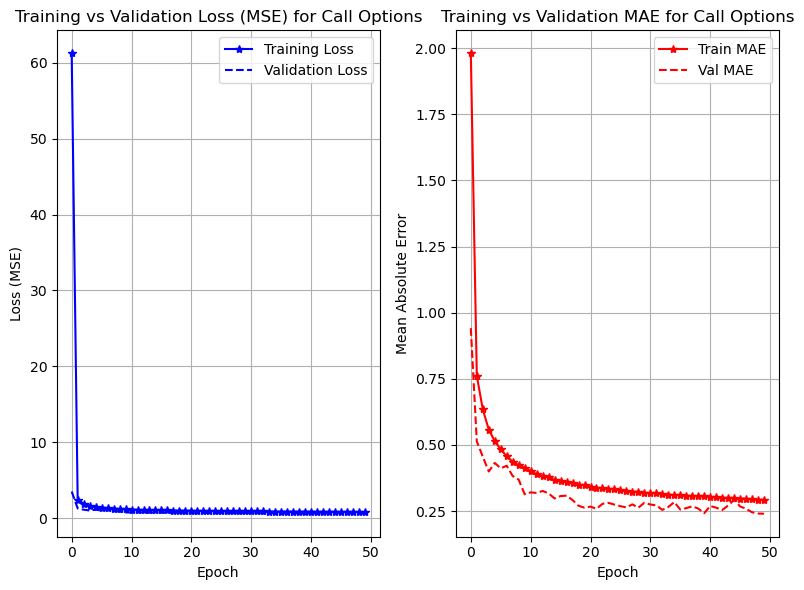

In [11]:
def plot_learning_curves(history, opt_type):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6))

    ax1.plot(history.epoch, history.history["loss"], '*-', label="Training Loss", color='b')
    ax1.plot(history.epoch, history.history["val_loss"], '--', label="Validation Loss", color='b')
    ax1.set_title(f"Training vs Validation Loss (MSE) for {opt_type} Options")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss (MSE)")
    ax1.grid(True)
    ax1.legend()
    
    ax2.plot(history.epoch, history.history["mae"], '*-', label="Train MAE", color='r')
    ax2.plot(history.epoch, history.history["val_mae"], '--', label="Val MAE", color='r')
    ax2.set_title(f"Training vs Validation MAE for {opt_type} Options")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Mean Absolute Error")
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(history_calls, "Call")

1617/1617 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


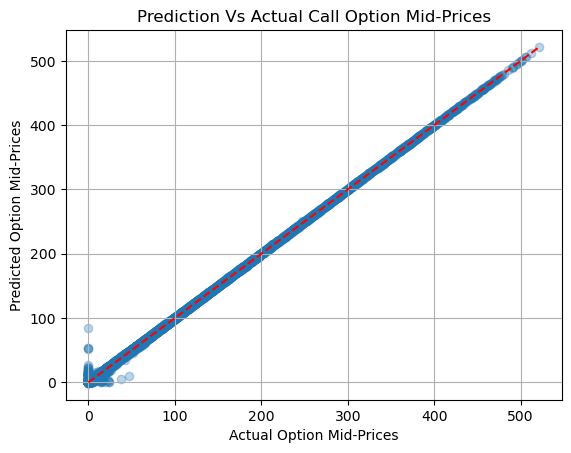

In [12]:
def get_prediction_plot(model, X_test_s, y_test, opt_type):
    y_pred = model.predict(X_test_s)
    
    plt.scatter(y_test, y_pred, marker = 'o', alpha = 0.3)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Option Mid-Prices")
    plt.ylabel("Predicted Option Mid-Prices")
    plt.title(f"Prediction Vs Actual {opt_type} Option Mid-Prices")
    plt.grid(True)
    plt.show()

get_prediction_plot(model_calls, X_test_scaled_c, 
                    y_test_c, "Call")

## Put option Model

In [14]:
model_puts = build_model(X_train_scaled_p.shape[1])

start = time.time()
history_puts = model_puts.fit(X_train_scaled_p, y_train_p,
             validation_data = (X_valid_scaled_p, y_valid_p),
             epochs = 50, verbose = 1, callbacks=[early_stop])
end = time.time()
baseline_time_p = end-start

mse_val_p, mae_val_p = model_puts.evaluate(X_valid_scaled_p,
                                            y_valid_p, verbose = 0)
test_loss_p, test_mae_p = model_puts.evaluate(X_test_scaled_p,
                                               y_test_p, verbose = 0)
print("\nPut Options:")
print(f"Validation MSE: {mse_val_p}")
print(f"Validation MAE: {mae_val_p}")

print(f"\nTest MSE: {test_loss_p}")
print(f"Test MAE: {test_mae_p}")

Epoch 1/50
7550/7550 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 409.7441 - mae: 4.1909 - val_loss: 18.4341 - val_mae: 1.9181
Epoch 2/50
7550/7550 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 7.8205 - mae: 1.1245 - val_loss: 6.7521 - val_mae: 1.1436
Epoch 3/50
7550/7550 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 6.1224 - mae: 0.9371 - val_loss: 5.2135 - val_mae: 0.9303
Epoch 4/50
7550/7550 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 5.0482 - mae: 0.8088 - val_loss: 3.4181 - val_mae: 0.6512
Epoch 5/50
7550/7550 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 4.5269 - mae: 0.7294 - val_loss: 3.3338 - val_mae: 0.6391
Epoch 6/50
7550/7550 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 4.2026 - mae: 0.6851 - val_loss: 2.9856 - val_mae: 0.5489
Epoch 7/50
7550/7550 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 3.9503 - mae: 0.6516 - val_loss: 3.1042 - val_mae: 0.6235
Epoch 8/50
7550/7550 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 3.7002 - mae: 0.6173 - val_loss: 3.3890 - val_mae: 0.6481
Epoch 9/50
7550/7550 ━━━━━━━━

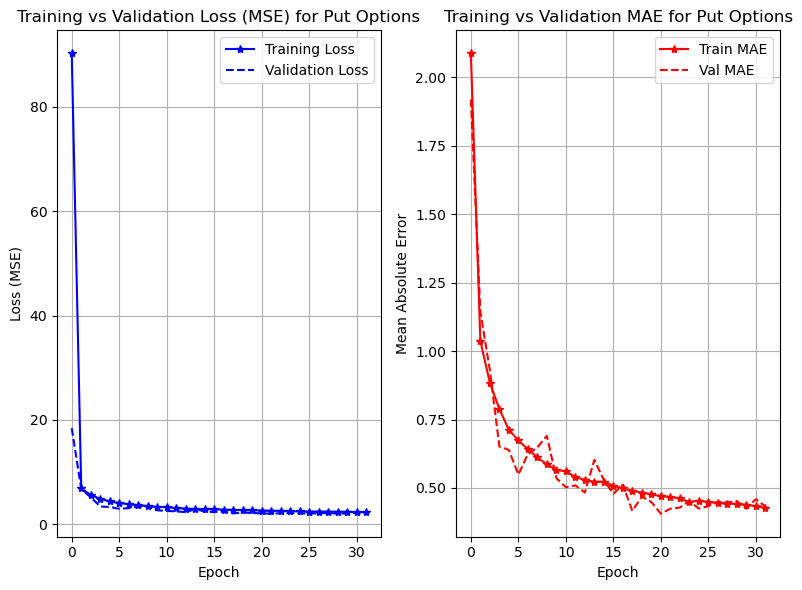

In [15]:
plot_learning_curves(history_puts, "Put")

1619/1619 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


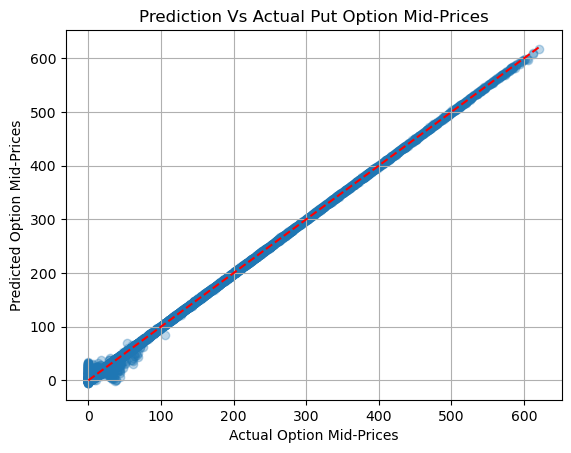

In [16]:
get_prediction_plot(model_puts, X_test_scaled_p, y_test_p, "Put")

## Hyperparameter search

To optimize the Neural Network model, we want to identify the best hyperparameter configuration which predicts the option's `mid_price` closest, to do this I will implement a randomized search. 

A few of the hyperparameters to optimize are: 
* Number of Hidden Layers
* Number of Neurons per layer
* Neuron activation function
* Neuron l2 regularization
* Learning rate
* Optimizer

To find the best configuration, we will select the number of hidden layers between 1 and 5, as adding more may be redundant. For the number of neurons, we will select a value between 10 and 100 neurons. Since deep neural networks often perform better with 'swish' activation rather than with 'ReLU', we will select the activation function between those two at random to assess which performs better. Our l2 regularizer and learning rate will be chosen from a range between 1e-6 and 1e-2 to allow a broader range of values in which to assess performance on. Lastly, the optimizer will be selected at random as either the 'Adam' optimizer or the adam optimizer with nesterov momentum ('Nadam') to assess which fits the model better. Once again we will include early stopping to avoid unneccessary training, but this time with a patience of 5, as we will only be training on 20 epochs instead of 50 due to time constraints. This randomized search will run for 30 iterations in order to assess the optimal parameters, which we will then compare the best model here against the baseline model on their test set performance.

### Call Option

In [20]:
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

def build_model(hp):
    reset_session()

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = (X_train_c.shape[1],)))

    n_hidden = hp.Int("n_hidden", 1, 5)
    for i in range(n_hidden):
        model.add(tf.keras.layers.Dense(
            hp.Int(f"n_neurons_{i+1}", 10, 100),
            activation = hp.Choice("activation", ["relu", 'swish']),
            kernel_regularizer = tf.keras.regularizers.l2(
            hp.Float("l2", 1e-6, 1e-4, sampling="log")
            ),
            kernel_initializer = "he_normal"
        ))
        
    model.add(tf.keras.layers.Dense(1))
    
    learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling = "log")
    optimizer_name = hp.Choice("optimizer", ["Adam", "Nadam"])
    
    if optimizer_name == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
  
    model.compile(loss="mse", metrics = ['mae'], optimizer=optimizer)
    return model

early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    mode = "min",
    restore_best_weights = True
)

In [24]:
# Train on subsets of training data for speed
X_train_c_sub = X_train_scaled_c[::5]
X_valid_c_sub = X_valid_scaled_c[::5]

y_train_c_sub = y_train_c[::5]
y_valid_c_sub = y_valid_c[::5]

random_search_tuner = kt.RandomSearch(
    build_model, 
    objective = "val_loss", 
    seed = 42, 
    max_trials = 30, 
    overwrite = True
)

random_search_tuner.search(X_train_c_sub, y_train_c_sub, epochs = 30, 
                    validation_data = (X_valid_c_sub, y_valid_c_sub), verbose = 1,
                          callbacks=[early_stop])

Trial 30 Complete [00h 02m 12s]
val_loss: 312.7833251953125

Best val_loss So Far: 0.7911428809165955
Total elapsed time: 00h 52m 53s


In [25]:
best_hyperparams_c = random_search_tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hyperparams_c.values

{'n_hidden': 2,
 'n_neurons_1': 98,
 'activation': 'swish',
 'l2': 3.186250401134588e-06,
 'learning_rate': 0.005108567100824006,
 'optimizer': 'Adam',
 'n_neurons_2': 86,
 'n_neurons_3': 34,
 'n_neurons_4': 45,
 'n_neurons_5': 50}

In [27]:
best_model_c = build_model(best_hyperparams_c)

start = time.time()
history_best_c = best_model_c.fit(X_train_scaled_c, y_train_c,
             validation_data = (X_valid_scaled_c, y_valid_c),
             epochs = 50, verbose = 1, callbacks=[early_stop])
end = time.time()
tuned_model_time_c = end - start

test_loss_best_c, test_mae_best_c = best_model_c.evaluate(X_test_scaled_c, y_test_c)
print("\nTest MSE:", test_loss_best_c)
print("Test MAE:", test_mae_best_c)

best_model_c.save("best_model_calls.keras")

Epoch 1/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 160.4927 - mae: 3.2377 - val_loss: 2.0149 - val_mae: 0.7111
Epoch 2/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 3.1720 - mae: 0.8601 - val_loss: 1.5199 - val_mae: 0.5948
Epoch 3/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2.4404 - mae: 0.7147 - val_loss: 2.9179 - val_mae: 0.7990
Epoch 4/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 1.8813 - mae: 0.6019 - val_loss: 1.9203 - val_mae: 0.6145
Epoch 5/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 1.6311 - mae: 0.5433 - val_loss: 2.7034 - val_mae: 0.7618
Epoch 6/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 1.6193 - mae: 0.5375 - val_loss: 1.4193 - val_mae: 0.5581
Epoch 7/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.5563 - mae: 0.5229 - val_loss: 1.4760 - val_mae: 0.6027
Epoch 8/50
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.5599 - mae: 0.5140 - val_loss: 0.8541 - val_mae: 0.3697
Epoch 9/50
7549/7549 ━━━━━━━━━

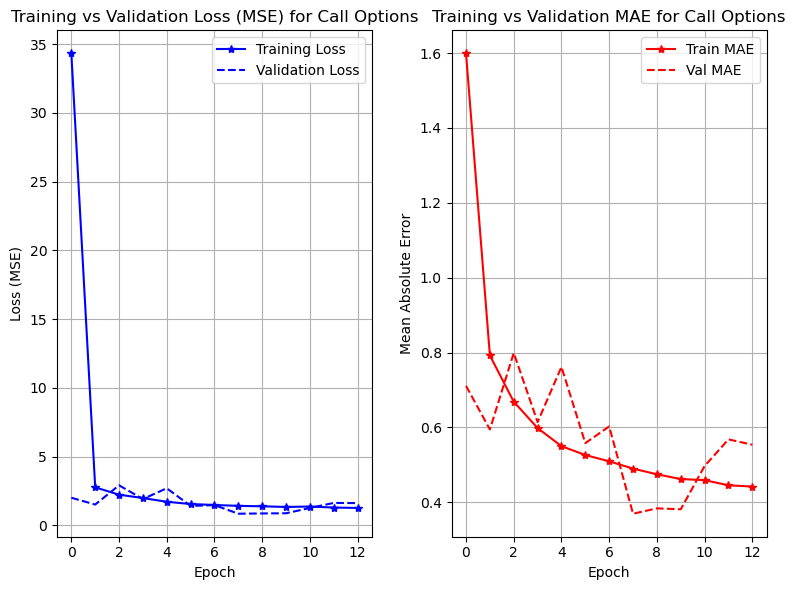

In [29]:
plot_learning_curves(history_best_c, "Call")

1617/1617 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


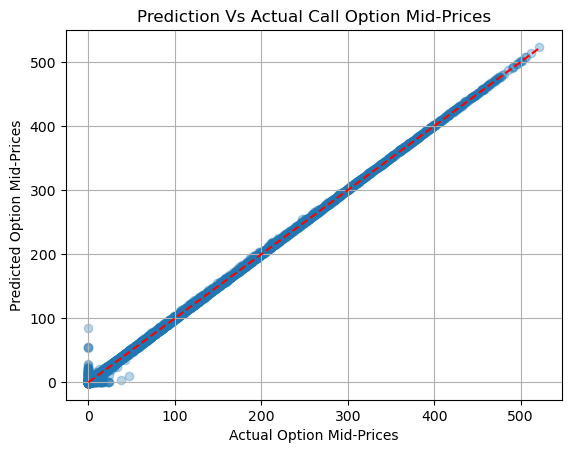

In [30]:
get_prediction_plot(best_model_c, X_test_scaled_c, 
                    y_test_c, "Call")

### Put Option

In [ ]:
X_train_p_sub = X_train_scaled_p[::5]
X_valid_p_sub = X_valid_scaled_p[::5]

y_train_p_sub = y_train_p[::5]
y_valid_p_sub = y_valid_p[::5]

random_search_tuner.search(X_train_p_sub, y_train_p_sub, epochs = 30, 
                    validation_data = (X_valid_p_sub, y_valid_p_sub), verbose = 1,
                          callbacks=[early_stop])

In [ ]:
best_hyperparams_p = random_search_tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hyperparams_p.values

In [ ]:
best_model_p = build_model(best_hyperparams_p)

start = time.time()
history_best_p = best_model_p.fit(X_train_scaled_p, y_train_p,
             validation_data = (X_valid_scaled_p, y_valid_p),
             epochs = 50, verbose = 1, callbacks=[early_stop])
end = time.time()
tuned_model_time_p = end - start

test_loss_best_p, test_mae_best_p = best_model_p.evaluate(X_test_scaled_p, y_test_p)
print("\nTest MSE:", test_loss_best_p)
print("Test MAE:", test_mae_best_p)

best_model_p.save("best_model_puts.keras")

In [ ]:
plot_learning_curves(history_best_p, "Put")

In [ ]:
get_prediction_plot(best_model_p, X_test_scaled_p, 
                    y_test_p, "Put")

In [33]:
results_df = pd.DataFrame([
    {
        'Model': 'Baseline',
        'Option Type': 'Call Option',
        'Layers': 4,
        'Activation': "ReLU",
        'Optimizer': "Nadam",
        'Epochs': 50,
        'MAE': round(test_mae_c, 4),
        'MSE': round(test_loss_c, 4),
        'Train Time (s)': round(baseline_time_c, 2)
    },
    {
        'Model': 'Tuned',
        'Option Type': 'Call Option',
        'Layers': str(best_hyperparams_c['n_hidden']),
        'Activation': best_hyperparams_c['activation'],
        'Optimizer': best_hyperparams_c['optimizer'],
        'Epochs': max(history_best_c.epoch),
        'MAE': round(test_mae_best_c, 4),
        'MSE': round(test_loss_best_c, 4),
        'Train Time (s)': round(tuned_model_time_c, 2)
    },
    {
        'Model': 'Baseline',
        'Option Type': 'Put Option',
        'Layers': 4,
        'Activation': "ReLU",
        'Optimizer': "Nadam",
        'Epochs': 50,
        'MAE': round(test_mae_p, 4),
        'MSE': round(test_loss_p, 4),
        'Train Time (s)': round(baseline_time_p, 2)
    },
    {
    'Model': 'Tuned',
    'Option Type': 'Put Option',
    'Layers': str(best_hyperparams_p['n_hidden']),
    'Activation': best_hyperparams_p['activation'],
    'Optimizer': best_hyperparams_p['optimizer'],
    'Epochs': max(history_best_p.epoch),
    'MAE': round(test_mae_best_p, 4),
    'MSE': round(test_loss_best_p, 4),
    'Train Time (s)': round(tuned_model_time_p, 2)
    }
])

display(results_df)

,Model,Option Type,Layers,Activation,Optimizer,Epochs,MAE,MSE,Train Time (s)
0,Baseline,Call Option,4,ReLU,Nadam,50,0.2407,0.7771,909.95
1,Tuned,Call Option,2,swish,Adam,12,0.3763,1.0668,217.74
2,Baseline,Put Option,4,ReLU,Nadam,50,0.4235,2.0323,562.09


In [ ]:
"""    """